In [22]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr
import seaborn as sns
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt



In [23]:
NOAA = xr.open_dataset(r'D:\CRI_Modelling_PC\Netcdf Data\NOAA\sst.annual.mean.ltm.1982-2010.PacificCoast.nc')
BS = xr.open_dataset(r"D:\CRI_Modelling_PC\Netcdf Data\Rolling\Ensemble_BS_TEMPS_RollingDaily.nc")
RCP = xr.open_dataset(r"D:\CRI_Modelling_PC\Netcdf Data\Rolling\Ensemble_RCP_TEMPS_RollingDaily.nc")
bathymetry = xr.open_dataset(r'D:\CRI_Modelling_PC\Bathymetry\crm.nc')
LandMask = xr.open_dataset(r'D:\CRI_Modelling_PC\Netcdf Data\mask.nc').mask

C:\ProgramData\Anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [24]:
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

In [25]:
BS_YM = BS.groupby('time.year').mean(dim='time').SurfaceTemp
RCP_YM = RCP.groupby('time.year').mean(dim='time').SurfaceTemp

Tlat = BS.lat.data
Tlon = BS.lon.data

C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [26]:
finalBath = bathymetry.Band1
Blat = finalBath.lat.data
Blon = finalBath.lon.data

In [27]:
NOAA_Masked = BS_YM[0,:,:]*0
iterLat = iterLon = 0
for x in LandMask.values:
    for y in x:
        if LandMask.values[iterLat][iterLon] == 0:
            NOAA_Masked[iterLat][iterLon] = NOAA.sst[0,iterLat,iterLon]
        else:
            NOAA_Masked[iterLat][iterLon] = None
        iterLon = iterLon+1
    iterLon = 0
    iterLat = iterLat+1

In [28]:
bathMask = finalBath.where((finalBath < -1) & (finalBath > -100))
bathMask = bathMask / bathMask

difference = RCP_YM.mean(dim='year').where(LandMask==0) - BS_YM.mean(dim='year').where(LandMask==0)
Adjusted_NOAA = NOAA_Masked + difference
#Adjusted_NOAA = Adjusted_NOAA.where(bathMask==1)


C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


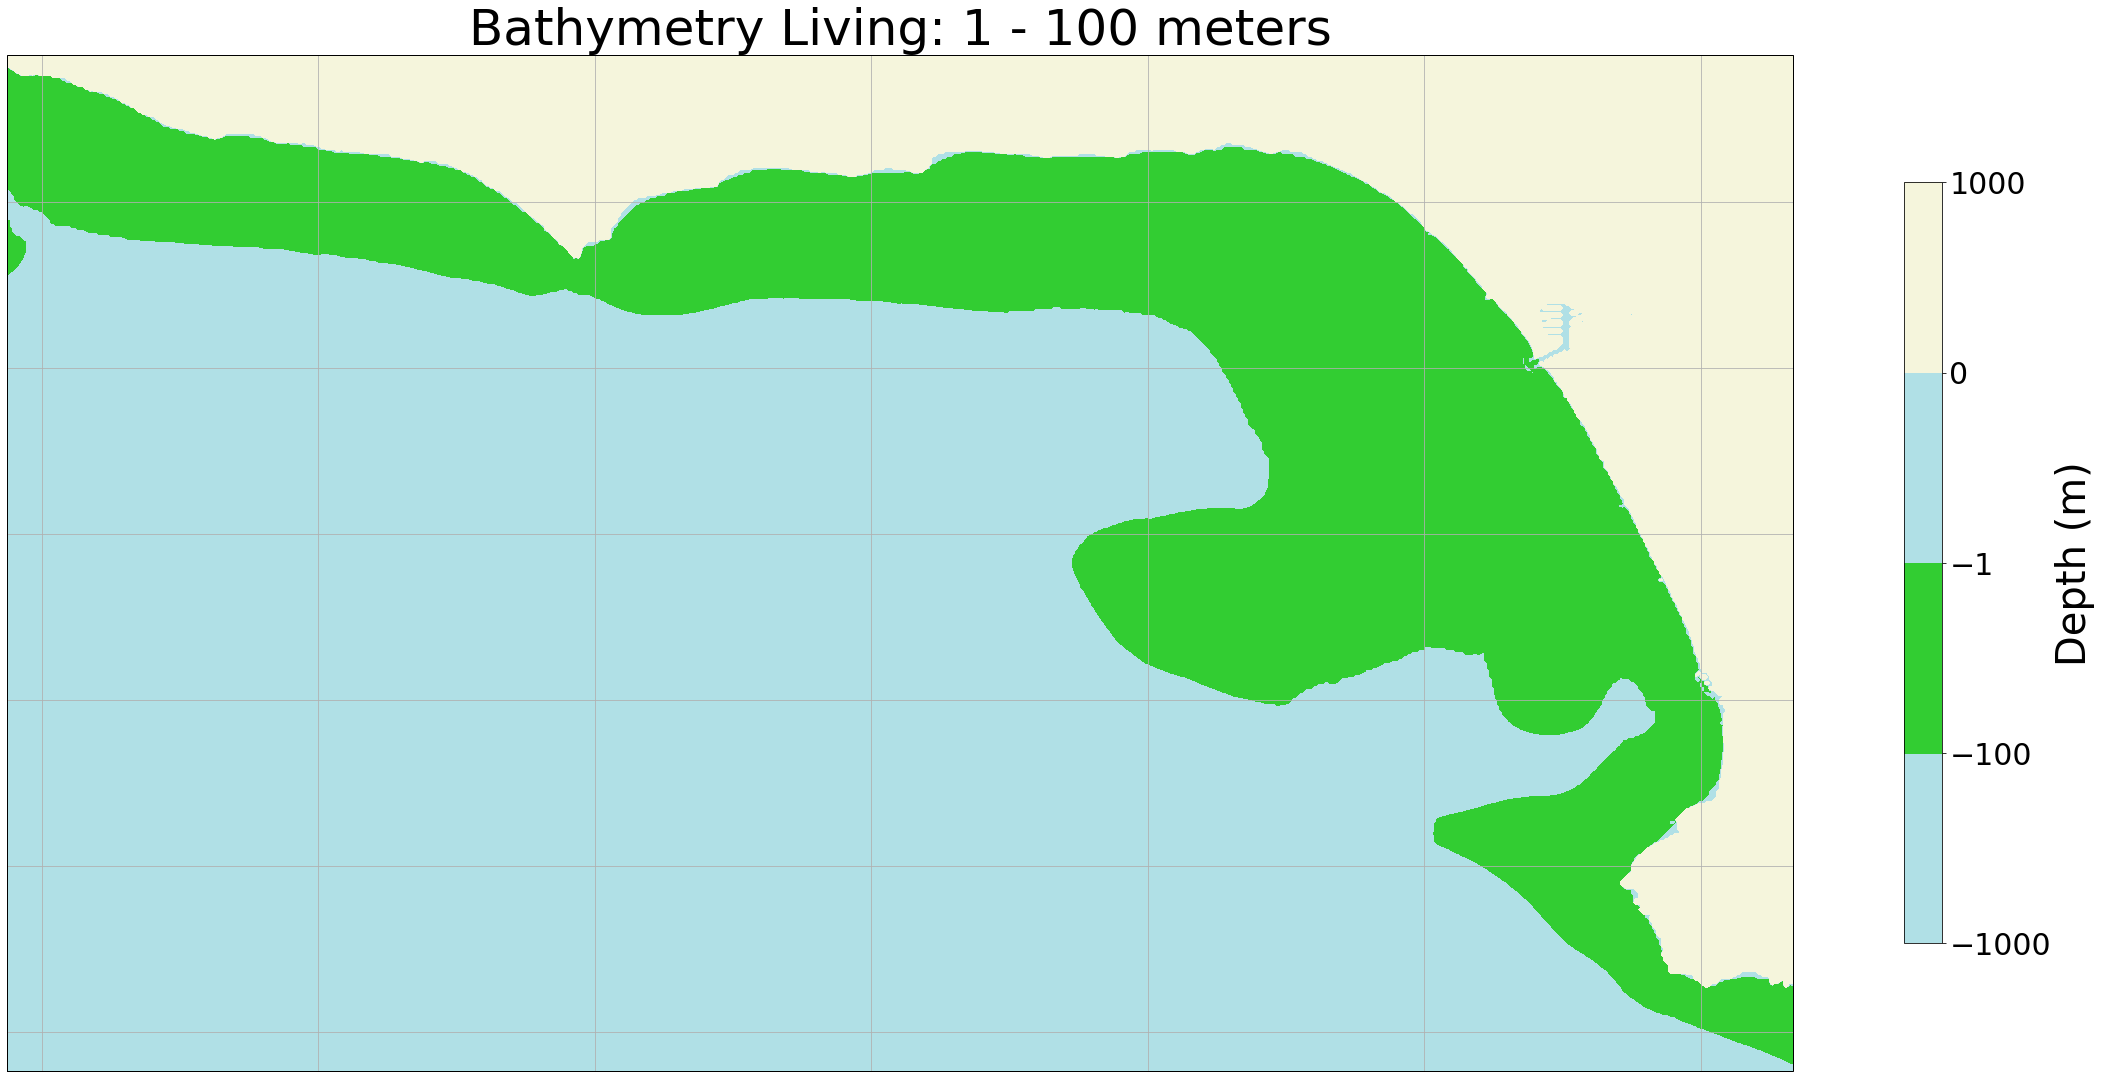

In [29]:
fig = plt.figure(figsize=[40,20])

plotBath = fig.add_subplot(1,1,1,projection=crs.PlateCarree())
plotBath.set_title('Bathymetry Living: 1 - 100 meters',fontsize=50)

levels = [-1000,-100,-1,0,1000]

c = ('powderblue', 'limegreen', 'powderblue','beige')

plot = plotBath.contourf(Blon, Blat, finalBath,levels,
             transform=crs.PlateCarree(),colors=c)

plotBath.gridlines()

colorbar = fig.colorbar(plot, shrink=0.7, anchor=('SW'))
colorbar.set_label('Depth (m)',fontsize=40)
colorbar.ax.tick_params(labelsize=30)

#fig.savefig(r"D:\CRI_Modelling_PC\CRI Maps\HAB 2020\HalibutBath.jpeg", bbox_inches='tight')

In [33]:
Adjusted_NOAA = bathMask[:,:]*0
BiterLat = BiterLon = 0


for x in bathMask.values:
    for y in x:
        if (BiterLat <200) and (BiterLon < 240):
            if bathMask.values[BiterLat][BiterLon] is None:
                Adjusted_NOAA[BiterLat][BiterLon] = None
            else:
                Adjusted_NOAA[BiterLat][BiterLon] = NOAA.sst[0][BiterLat][BiterLon]
        BiterLon = BiterLon + 1
    BiterLon = 0
    BiterLat = BiterLat + 1


'''for x in Adjusted_NOAA.values:
    for y in x:
        if Adjusted_NOAA.values[BiterLat][BiterLon] is None:
            bathMask[BiterLat][BiterLon] = None
        else:
            bathMask[BiterLat][BiterLon] = NOAA.sst[0][BiterLat][BiterLon]
        BiterLon = BiterLon + 1
    BiterLon = 0
    BiterLat = BiterLat + 1'''

#BathNOAA_Masked = ma.array(Adjusted_NOAA, mask=BathNOAA)

'for x in Adjusted_NOAA.values:\n    for y in x:\n        if Adjusted_NOAA.values[BiterLat][BiterLon] is None:\n            bathMask[BiterLat][BiterLon] = None\n        else:\n            bathMask[BiterLat][BiterLon] = NOAA.sst[0][BiterLat][BiterLon]\n        BiterLon = BiterLon + 1\n    BiterLon = 0\n    BiterLat = BiterLat + 1'

"ax1.add_feature(cfeature.COASTLINE)\nax1.add_feature(cfeature.LAND)\nax1.add_feature(states_provinces, edgecolor='gray')\nax1.add_feature(cfeature.BORDERS)\nax1.gridlines()\n\n"

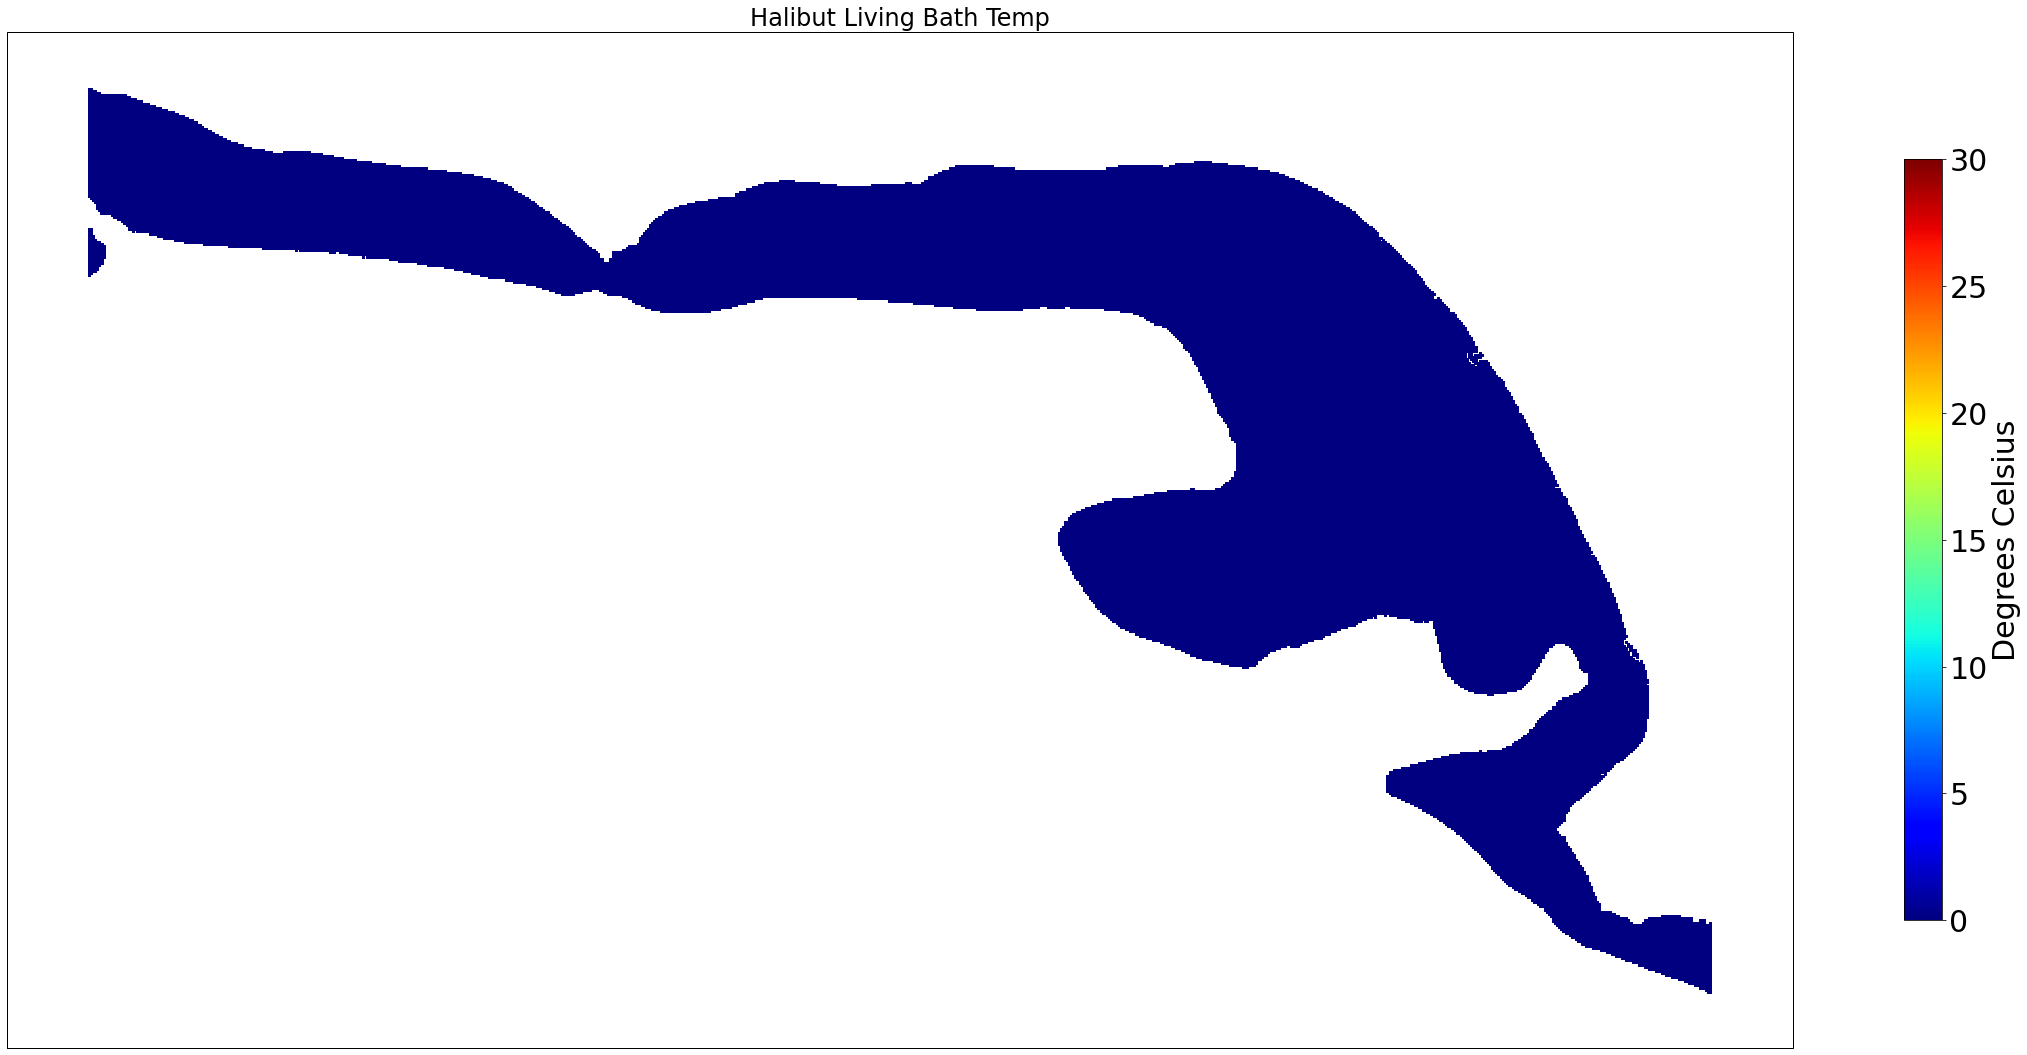

In [38]:

fig2 = plt.figure(figsize=[40, 20])
ax1 = fig2.add_subplot(1,1,1,projection=crs.PlateCarree())
ax1.set_title('Halibut Living Bath Temp', fontsize=24)
#ax1.set_extent([233,242,30,45], crs.Geodetic())


living_temp = ax1.pcolormesh(Blon, Blat,Adjusted_NOAA.where(bathMask==1),
             transform=crs.PlateCarree(),
             cmap='jet', vmin=0, vmax=30)


plotBath.gridlines()
colorbar = fig2.colorbar(living_temp, anchor=('SW'), shrink=0.7)
colorbar.set_label('Degrees Celsius', fontsize=30)
colorbar.ax.tick_params(labelsize=30)

'''ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.LAND)
ax1.add_feature(states_provinces, edgecolor='gray')
ax1.add_feature(cfeature.BORDERS)
ax1.gridlines()

'''



In [ ]:
#Adjusted_NOAA[0][0].data

In [ ]:
#bathMask.lon

In [ ]:
#BathNOAA[0].coords

In [ ]:
#Adjusted_NOAA.groupby('lat')
#

In [ ]:
#BathNOAA = NOAA[:,:]*0
#BathNOAA[0].coords

In [ ]:
bathMask.keys

In [ ]:
Adjusted_NOAA.shape

In [ ]:
BathNOAA.size

In [ ]:
temp.shape

In [ ]:
list(BathNOAA.values)